# <center>KGEMs Benchmarking</center>

This notebook contains the code to:
- Compute precision@100 a KGEM.
- Getting boxplots with precision@100 with all trials of a KGEM.

In [1]:
import os
from pathlib import Path
import sys

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append('../')
from src import analysis

PLOTS_PATH = '../data/plots'
PREDICTIONS_PATH = '../data/predictions'

mpl.rcParams['figure.dpi'] = 360
sns.set_style('whitegrid')

## Load predictions

In [2]:
all_trials_fn = os.path.join(PREDICTIONS_PATH, "all_trials_top100.csv")

if os.path.exists(all_trials_fn):
    predictions = pd.read_csv(all_trials_fn, sep="\t")
else:
    prediction_files = [p for p in Path(PREDICTIONS_PATH).glob("preds_*-trial_*-test.csv")]

    predictions = pd.DataFrame([])
    for csv in prediction_files:
        df = pd.read_csv(csv, sep="\t")
        try:
            df = df.sort_values("score", ascending=False).reset_index()
        except KeyError as e:
            print(csv)
            raise e
        predictions = pd.concat([predictions, df.head(100)], ignore_index=True)

    predictions.to_csv(os.path.join(PREDICTIONS_PATH, "all_trials_top100.csv"), sep="\t", index=False)
    
predictions = predictions.rename({"head_label": "source", "tail_label": "target"}, axis=1)
predictions = predictions[["kg", "model", "trial_k", "source", "target", "score"]]
predictions["dataset"] = "test"

# Compute precision

In [3]:
def compute_precision(predictions, K=100):    
    precision_data = []
    precision_columns = ["kg", "model", "trial", "precision"]
    predictions_gt = analysis.add_ground_truth(predictions)
    for kg in predictions_gt.kg.unique():
        df_kg = predictions_gt[predictions_gt.kg == kg]
        print(kg)
        for model in df_kg.model.unique():
            df_model = df_kg[df_kg["model"] == model]
            print(model)
            for trial in df_model.trial_k.unique():
                print(trial)
                df_trial = df_model[df_model["trial_k"] == trial].sort_values('score', ascending=False).head(K)
                # df_with_gt = analysis.add_ground_truth(df_trial)
                true_positives = len(df_trial[df_trial["y"] == 1])
                precision_data.append([
                    kg, model, trial, (true_positives/K)*100,
                ])

    precision = pd.DataFrame(precision_data, columns=precision_columns)
    return precision

In [4]:
precision_fn = os.path.join(PREDICTIONS_PATH, "trials_top100_precision.csv")
if os.path.exists(precision_fn):
    precision_100 = pd.read_csv(precision_fn, sep="\t")
else:
    precision_100 = compute_precision(predictions)
    precision_100.to_csv(precision_fn, sep="\t", index=False)

In [5]:
precision_fn = os.path.join(PREDICTIONS_PATH, "trials_top10_precision.csv")
if os.path.exists(precision_fn):
    precision_10 = pd.read_csv(precision_fn, sep="\t")
else:
    precision_10 = compute_precision(predictions, K=10)
    precision_10.to_csv(precision_fn, sep="\t", index=False)

# Plot Trials' precision

### Auxiliary functions

In [6]:
kg2title = {
    'openbiolink': 'OpenBioLink',
    'biokg': 'BioKG',
}

model2title = {
    'rescal': 'RESCAL',
    'transe': 'TransE',
    'distmult': 'DistMult',
    'ermlp': 'ERMLP',
    'transh': 'TransH',
    'complex': 'ComplEx',
    'hole': 'HolE',
    'conve': 'ConvE',
    'rotate': 'RotatE',
    'mure': 'MuRE',   
}

def create_legend(models, palette):
    patches = []
    for model, color in zip(models, palette):
        patch = mpatches.Patch(color=color, label=model)
        patches.append(patch)
    return patches
    

def plot_precision_box_plot(
    df,
    title=None,
    ylabel='Precision (%)',
    ylim=(0, 100),
    nrows=2,
    ncols=1,
    figsize=(22,18),
    save_to=None
):
    df = df.sort_values(["model", "precision"], ascending=[False, False])
    df["model"] = df["model"].apply(lambda x: model2title[x])
    models = df.model.unique()
    palette = sns.color_palette('hls', n_colors=len(models))
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, (ax, kg) in enumerate(zip(axs, df.kg.unique())):

        sns.boxplot(
            data=df[(df['kg'] == kg)],
            y='precision',
            x="model",
            palette=palette,
            ax=ax,
        )
        ax.set_title(kg2title[kg], y=1.0, pad=10, fontsize=25)
        ax.set_ylim(ylim)
        ax.set_xlabel('')
        ax.set_ylabel(ylabel, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=18)
    
    if title is not None:
        fig.suptitle(title, fontsize=25, y=1.0)

    plt.tight_layout()
    plt.subplots_adjust(
        hspace=0.2,
    )
    if save_to is not None:
        plt.savefig(os.path.join(PLOTS_PATH, save_to), dpi=360)

## Precision@100

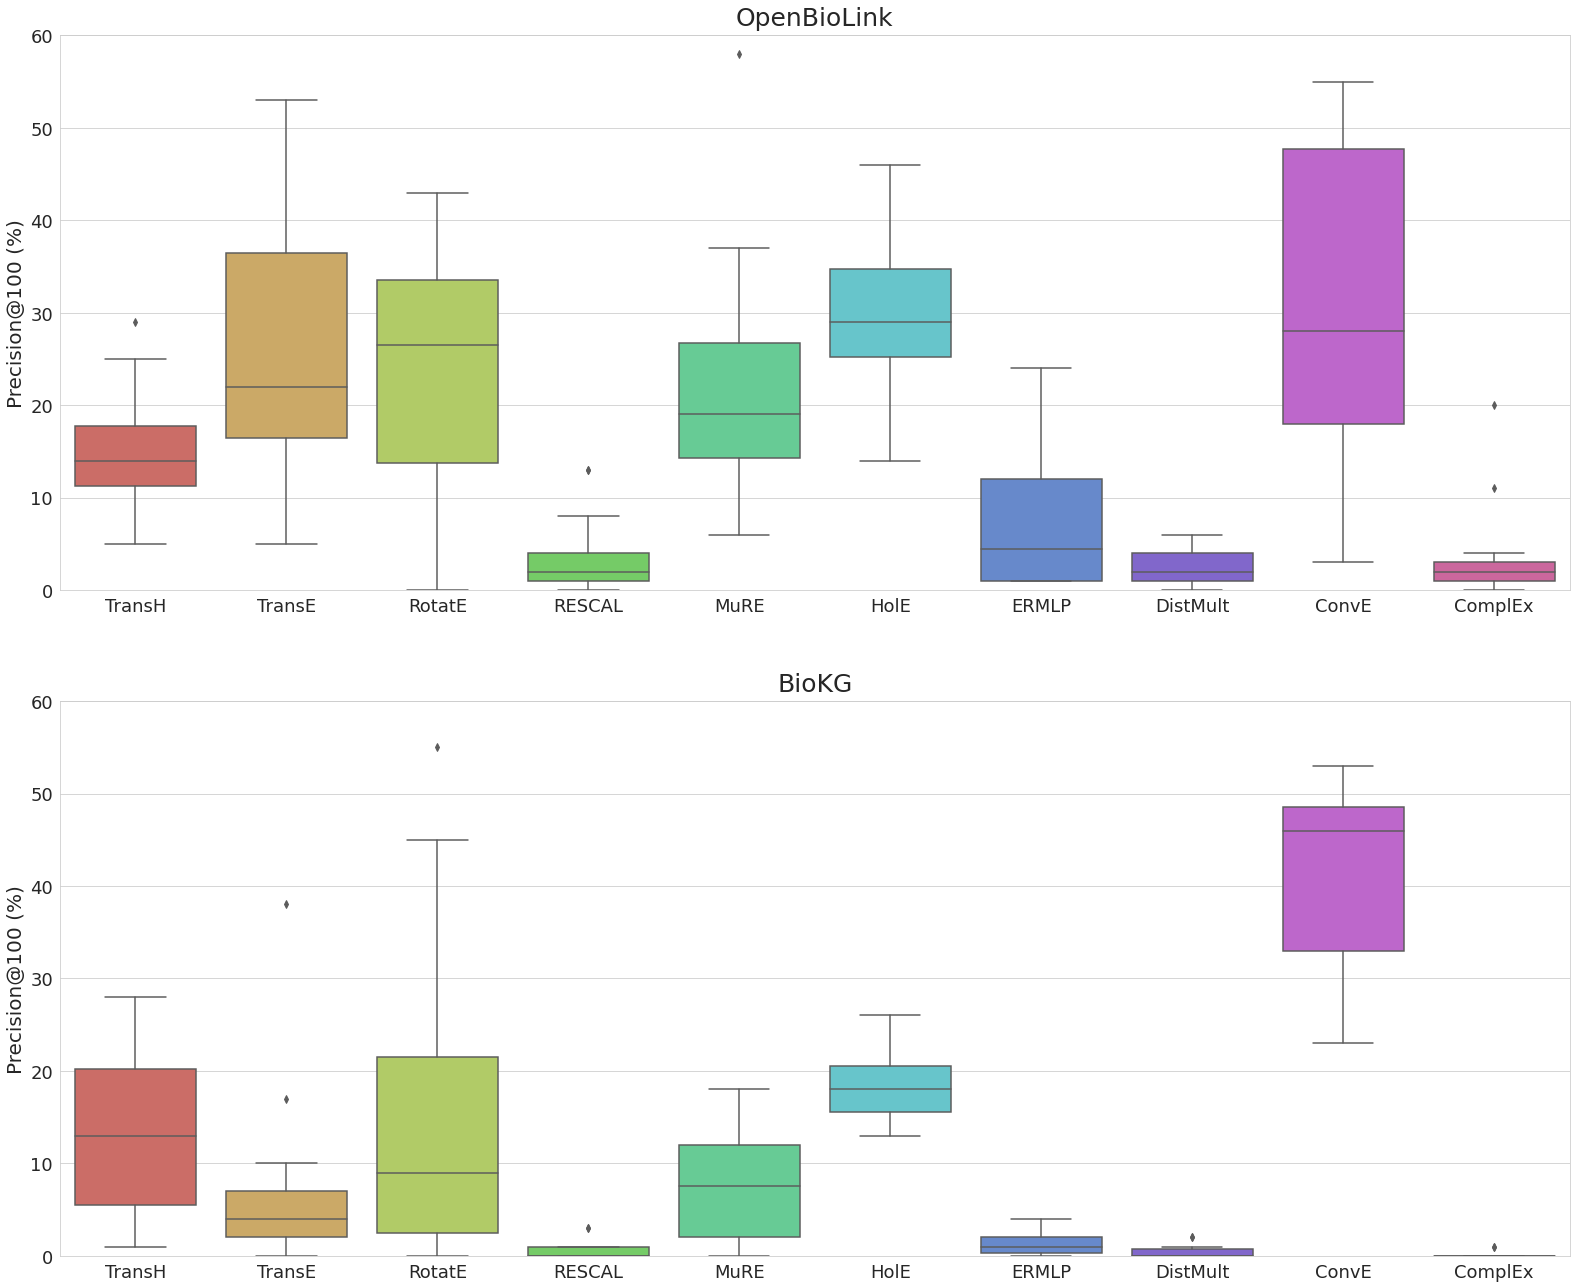

In [7]:
plot_precision_box_plot(
    precision_100,
    ylabel='Precision@100 (%)',
    ylim=(0, 60),
    save_to="precision_boxplot_at100.png",
)

## Precision@10

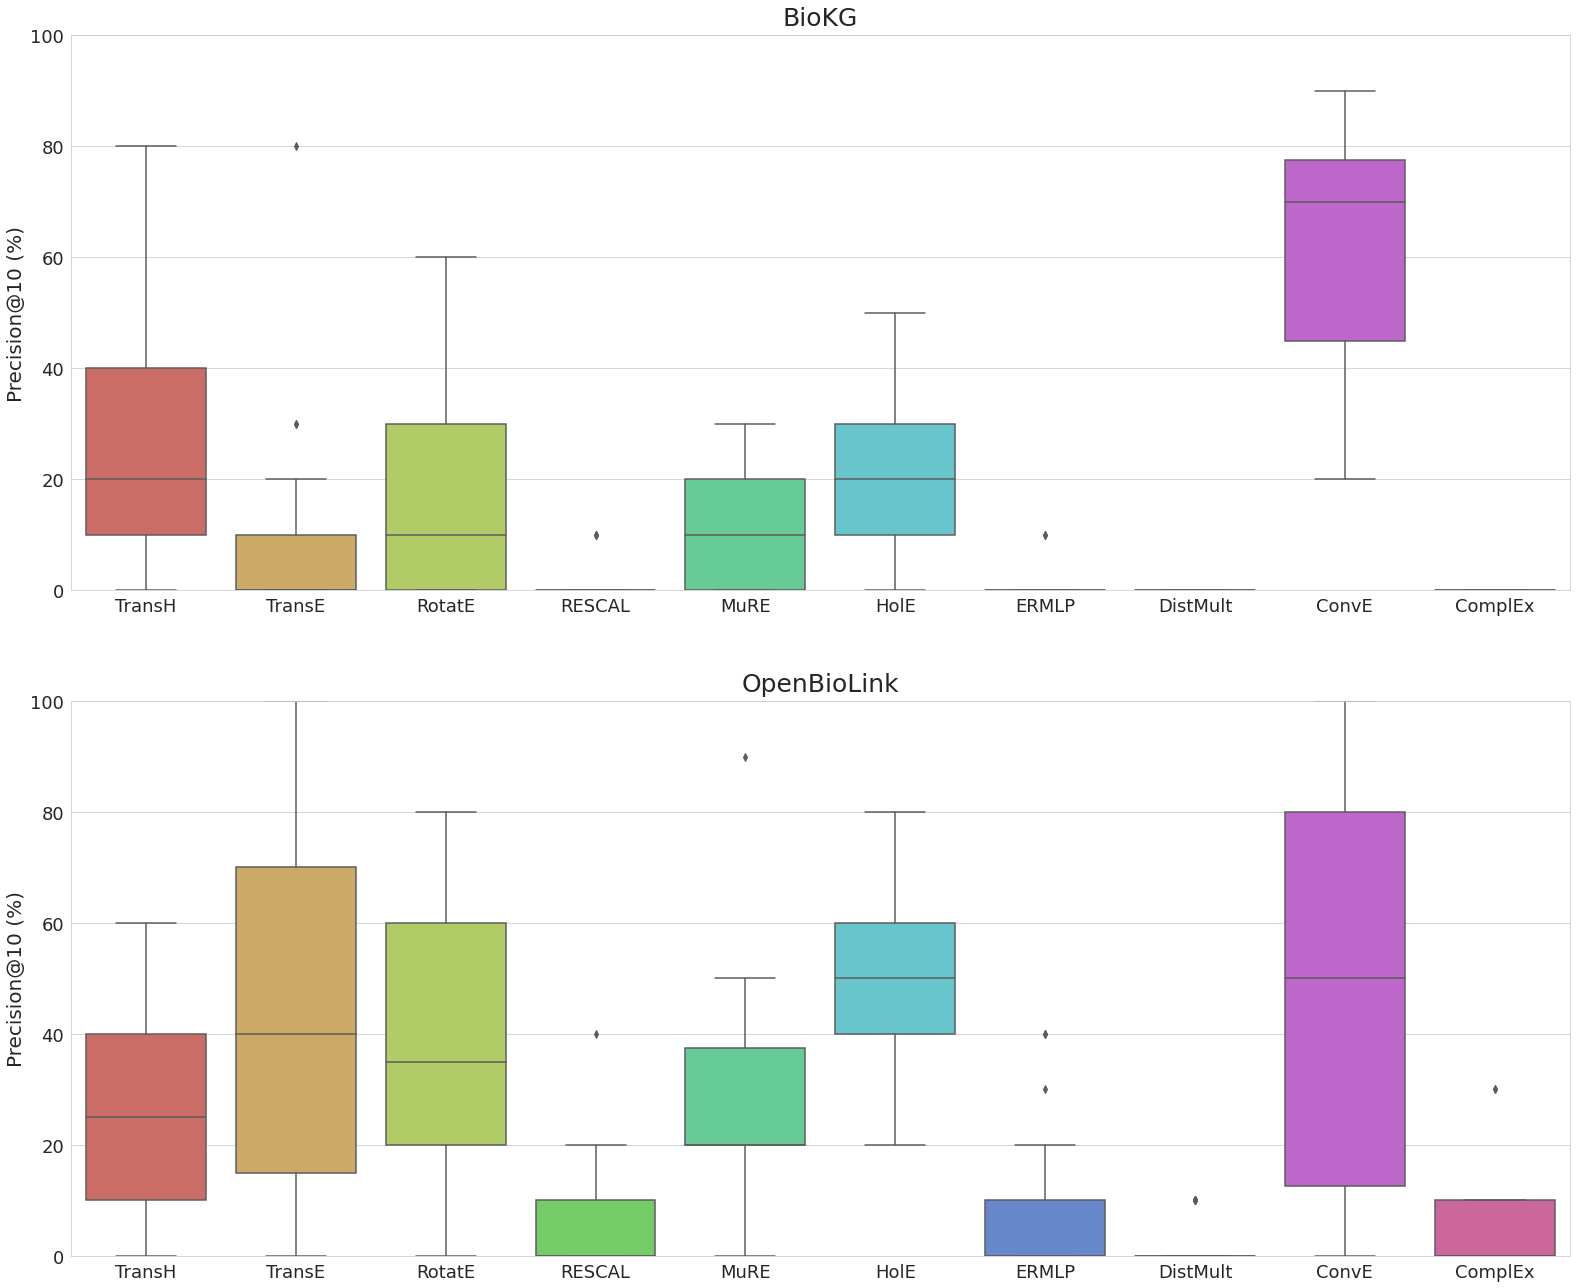

In [8]:
plot_precision_box_plot(
    precision_10,
    ylabel='Precision@10 (%)',
    ylim=(0,100),
    save_to="precision_boxplot_at10.png",
)